In [1]:
import os

import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
price_df = pd.read_csv("gecko_price.csv", index_col=0)
mktcap_df = pd.read_csv("gecko_marketcap.csv", index_col=0)

price_df.index = pd.to_datetime(price_df.index)
mktcap_df.index = pd.to_datetime(mktcap_df.index)

In [3]:
daily_return = price_df.pct_change()
weekly_return = price_df.pct_change(7)

problematic_cols = []
for col in daily_return.columns:
    if daily_return[col].max() > 10000:
        problematic_cols.append(col)

daily_return = daily_return.drop(problematic_cols, axis=1)
weekly_return = weekly_return.drop(problematic_cols, axis=1)
mktcap_df = mktcap_df.drop(problematic_cols, axis=1)

In [4]:
screen_by_mktcap = mktcap_df.applymap(lambda x: 1 if x>1_000_000 else np.nan)

In [5]:
problematic_idxs = []

count_before = 0
tmp = screen_by_mktcap.count(axis=1)
for idx in tqdm(screen_by_mktcap.index):
    target_val = tmp.loc[idx]
    if count_before != 0:
        if (target_val - count_before) / count_before < -0.5:
            #print(idx)
            problematic_idxs.append(idx)
    count_before = target_val

100%|██████████| 3593/3593 [00:00<00:00, 71923.86it/s]


In [6]:
daily_return = daily_return.drop(problematic_idxs, axis=0)
weekly_return = weekly_return.drop(problematic_idxs, axis=0)
pf_mktcap_weighted = mktcap_df.drop(problematic_idxs, axis=0)
mktcap_df = mktcap_df.drop(problematic_idxs, axis=0)
screen_by_mktcap = screen_by_mktcap.drop(problematic_idxs, axis=0)

In [7]:
mktcap_df_screened = mktcap_df * screen_by_mktcap

In [8]:
mktcap_df_screened.count(axis=1)

2013-04-28      4
2013-04-29      3
2013-04-30      4
2013-05-01      4
2013-05-02      3
             ... 
2023-02-24    208
2023-02-25    209
2023-02-26    204
2023-02-27    202
2023-02-28    201
Length: 3587, dtype: int64

In [9]:
mktcap_weight = mktcap_df_screened.apply(lambda x: x/np.nansum(x), axis=1)
tmp = mktcap_df_screened.copy()
tmp[tmp.isna()==False] = 1
equal_weight = tmp.apply(lambda x: x/x.count(), axis=1)

In [10]:
equal_weight.count(axis=1)

2013-04-28      4
2013-04-29      3
2013-04-30      4
2013-05-01      4
2013-05-02      3
             ... 
2023-02-24    208
2023-02-25    209
2023-02-26    204
2023-02-27    202
2023-02-28    201
Length: 3587, dtype: int64

<AxesSubplot:>

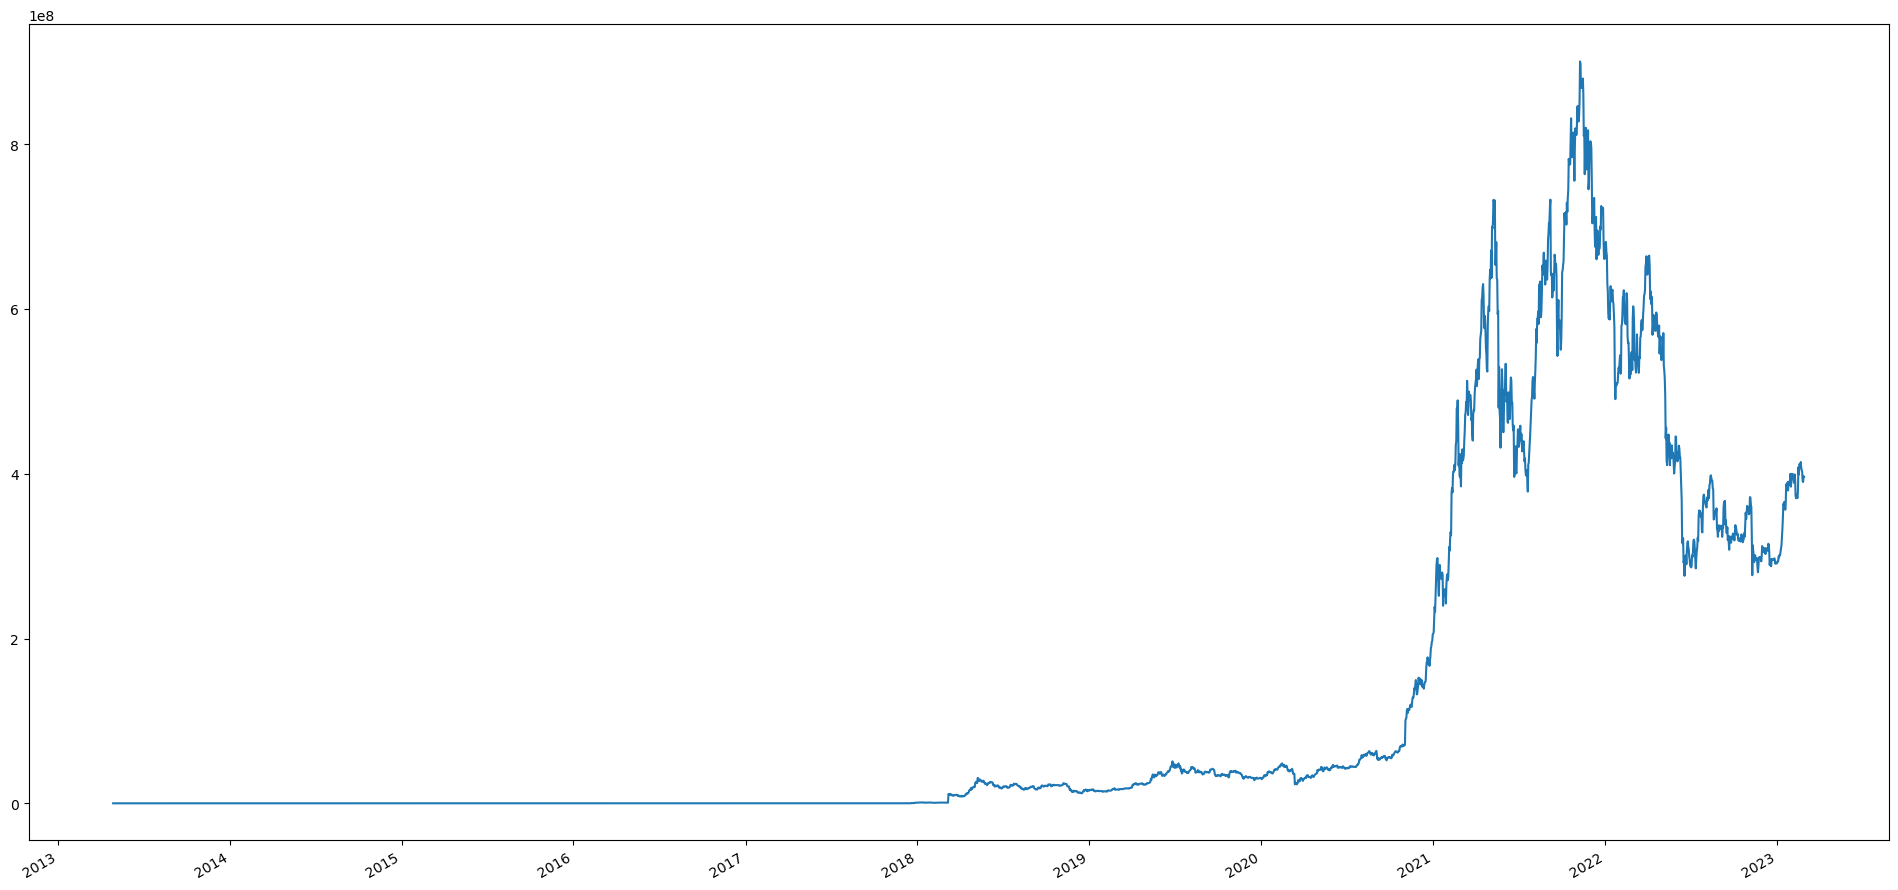

In [11]:
pf_return = (daily_return*mktcap_weight).sum(axis=1)

plt.figure(figsize=(24,12))
(pf_return+1).cumprod().loc[:].plot()

In [12]:
pf_self_daily_return = (pf_return+1).cumprod().pct_change(1)
pf_self_weekly_return = (pf_return+1).cumprod().pct_change(7)

In [13]:
q1_pf_return = pf_self_weekly_return[pf_self_weekly_return >= pf_self_weekly_return.quantile(0.66)]

q2_pf_return = pf_self_weekly_return[pf_self_weekly_return < pf_self_weekly_return.quantile(0.66)]
q2_pf_return = q2_pf_return[q2_pf_return >= pf_self_weekly_return.quantile(0.33)]

q3_pf_return = pf_self_weekly_return[pf_self_weekly_return < pf_self_weekly_return.quantile(0.33)]

In [14]:
yesterday_q1 = []
yesterday_q2 = []
yesterday_q3 = []

q1_index = q1_pf_return.index
q2_index = q2_pf_return.index
q3_index = q3_pf_return.index

tmp_index = pf_self_daily_return.index
for i in range(len(tmp_index)-1):
    current_index = tmp_index[i]
    if current_index in q1_index:
        yesterday_q1.append(pf_self_daily_return.loc[current_index])
    elif current_index in q2_index:
        yesterday_q2.append(pf_self_daily_return.loc[current_index])
    elif current_index in q3_index:
        yesterday_q3.append(pf_self_daily_return.loc[current_index])

<AxesSubplot:>

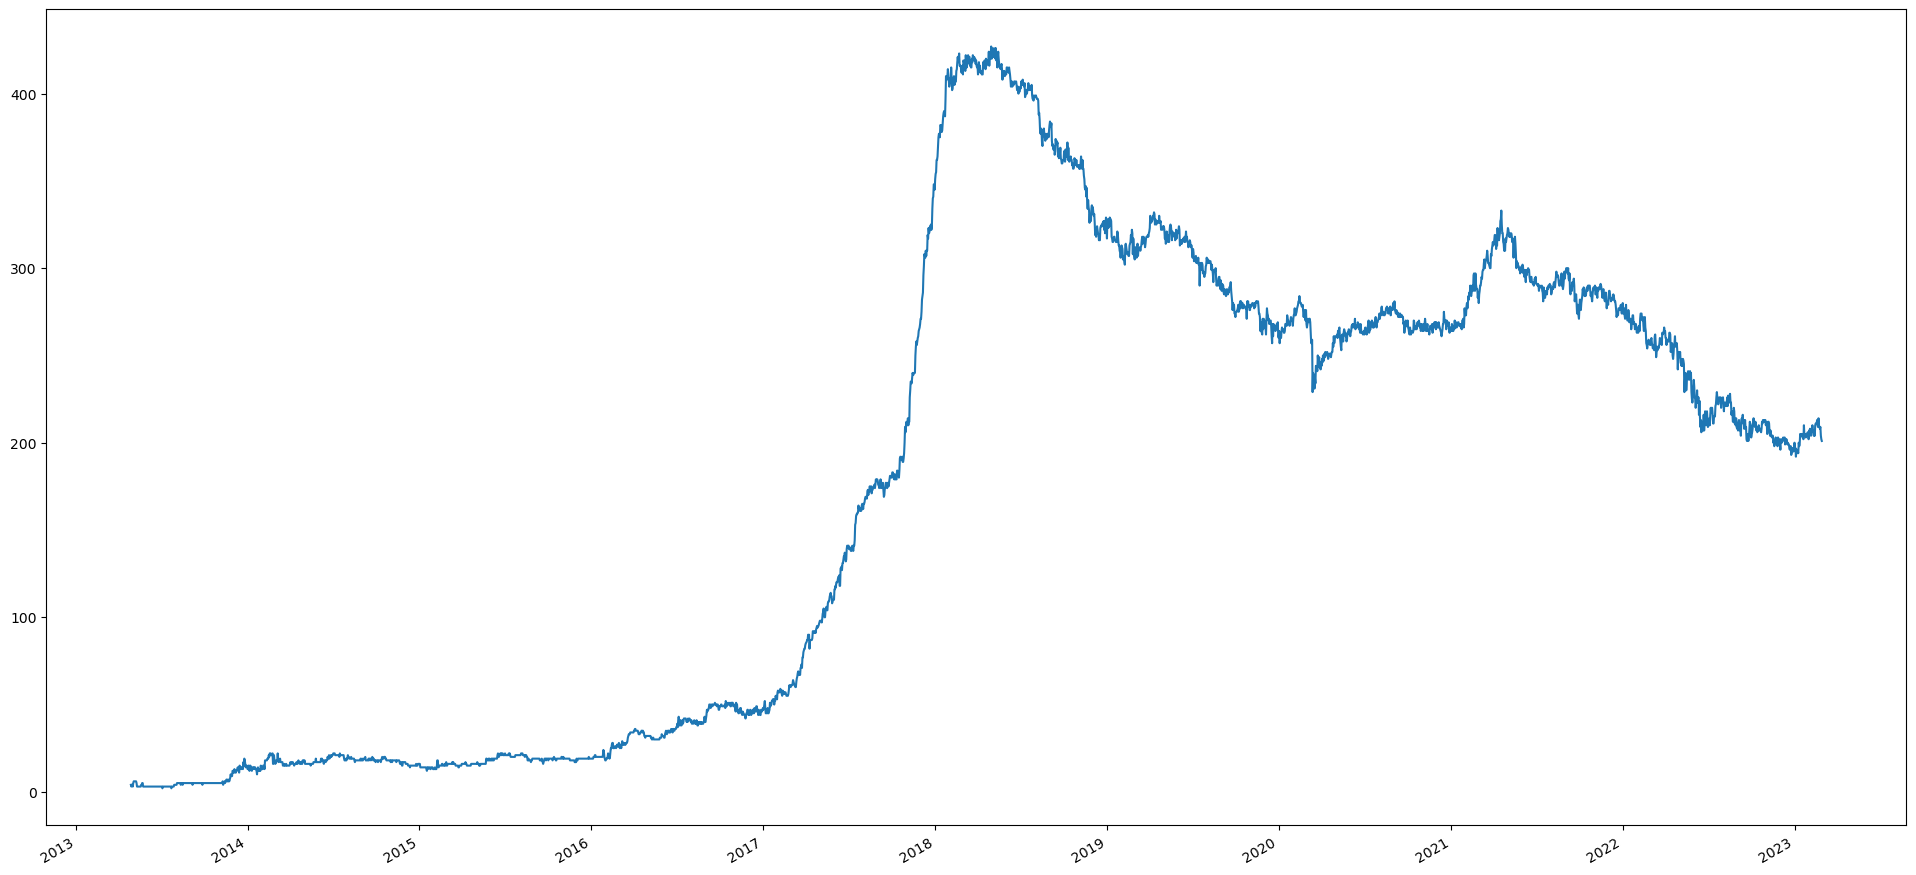

In [15]:
plt.figure(figsize=(24,12))
screen_by_mktcap.count(axis=1).plot()

Cross-Sectional Regression

In [52]:
q1_bound = daily_return.apply(lambda x: np.nanquantile(x, 0.333), axis=1)
q2_bound = daily_return.apply(lambda x: np.nanquantile(x, 0.666), axis=1)
# q2가 더 큰 수임

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [61]:
q1_mask = daily_return.apply(lambda x: x < q1_bound, axis=0)
q2_mask = (daily_return.apply(lambda x: x >= q1_bound, axis=0)) & \
          (daily_return.apply(lambda x: x < q2_bound, axis=0))
q3_mask = daily_return.apply(lambda x: x >= q2_bound, axis=0)

In [92]:
# 횡단면 Momentum의 분위수로 screening 한 것의 weight를 구함
q1_weight = (q1_mask * mktcap_df_screened) \
            .apply(lambda x: x / np.nansum(x), axis=1)
q2_weight = (q2_mask * mktcap_df_screened) \
            .apply(lambda x: x / np.nansum(x), axis=1)
q3_weight = (q3_mask * mktcap_df_screened) \
            .apply(lambda x: x / np.nansum(x), axis=1)

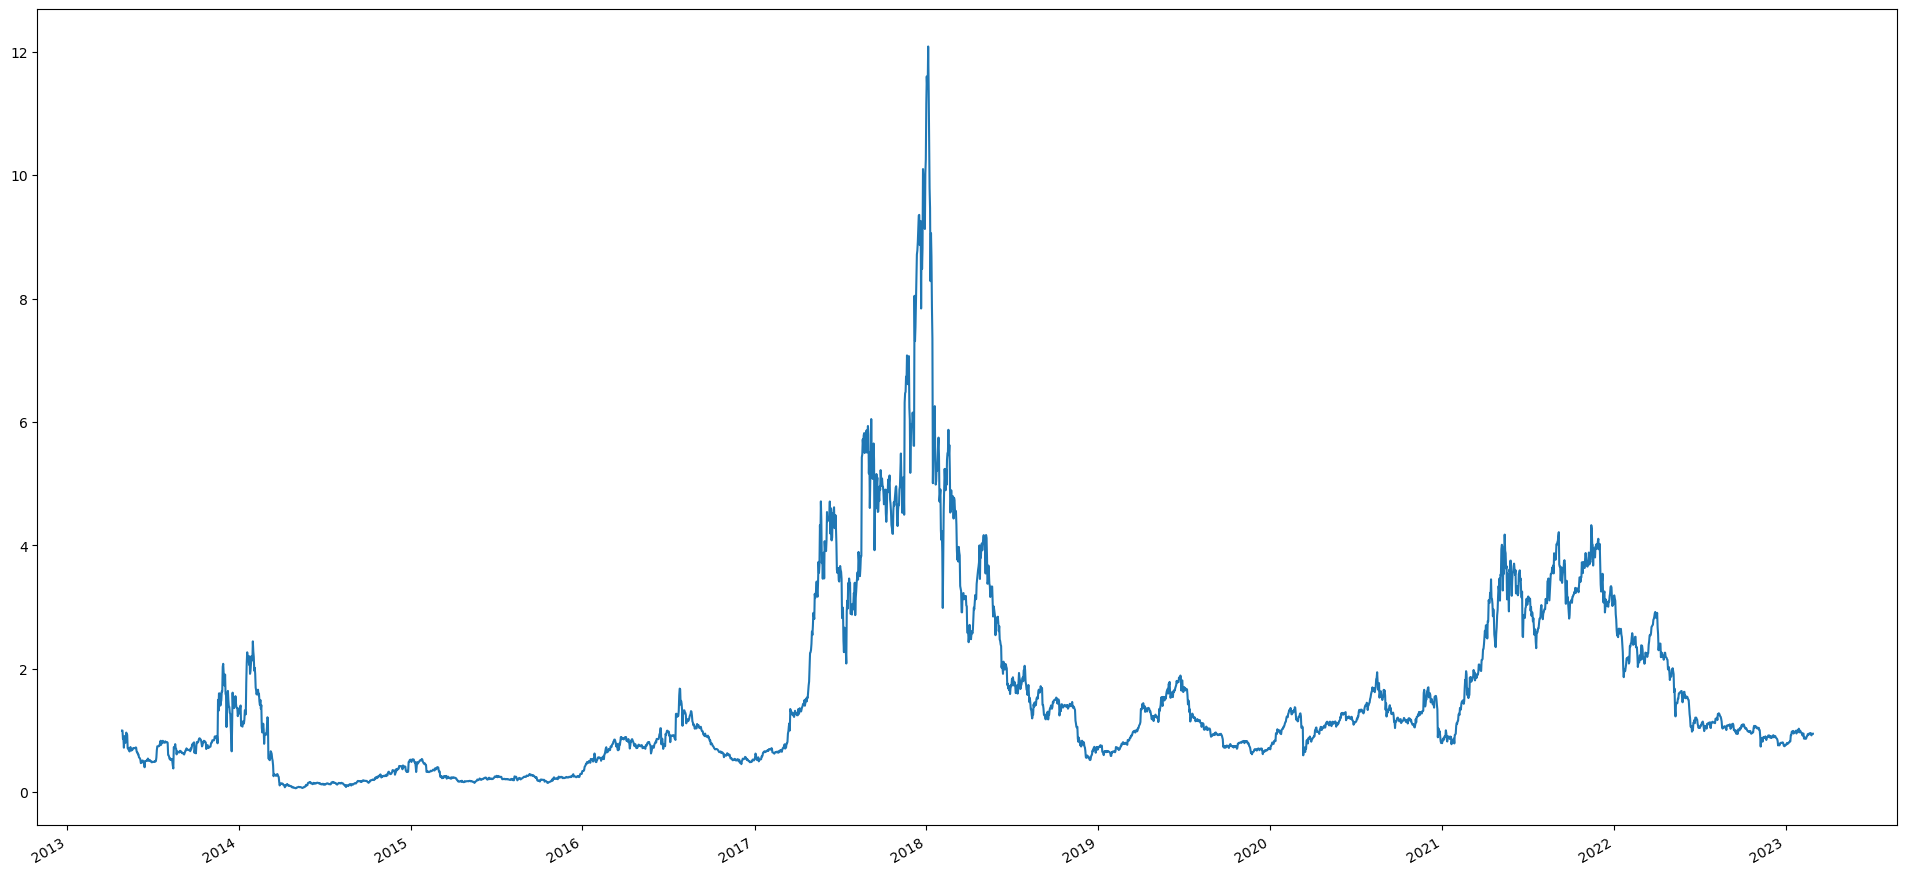

In [109]:
# weight된 수익률을 구함
((q1_weight * daily_return.shift(-1)).sum(axis=1) + 1) \
                          .cumprod() \
                          .plot(figsize=(24,12));

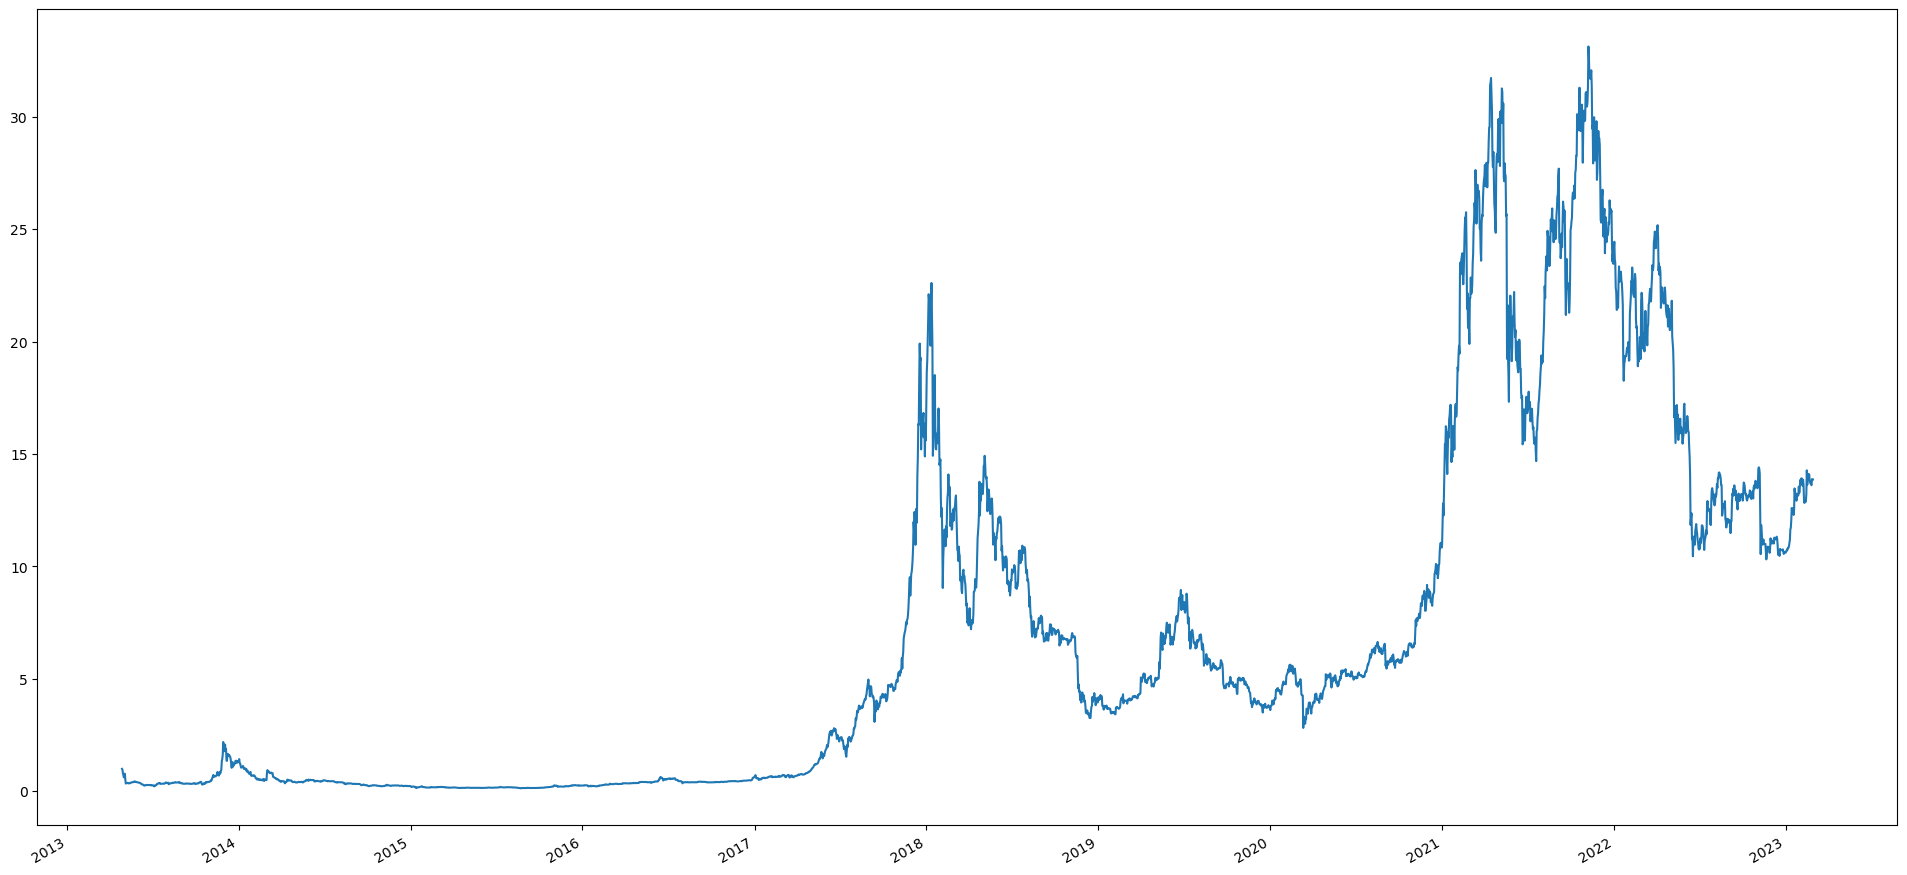

In [108]:
((q2_weight * daily_return.shift(-1)).sum(axis=1) + 1).cumprod().plot(figsize=(24,12));

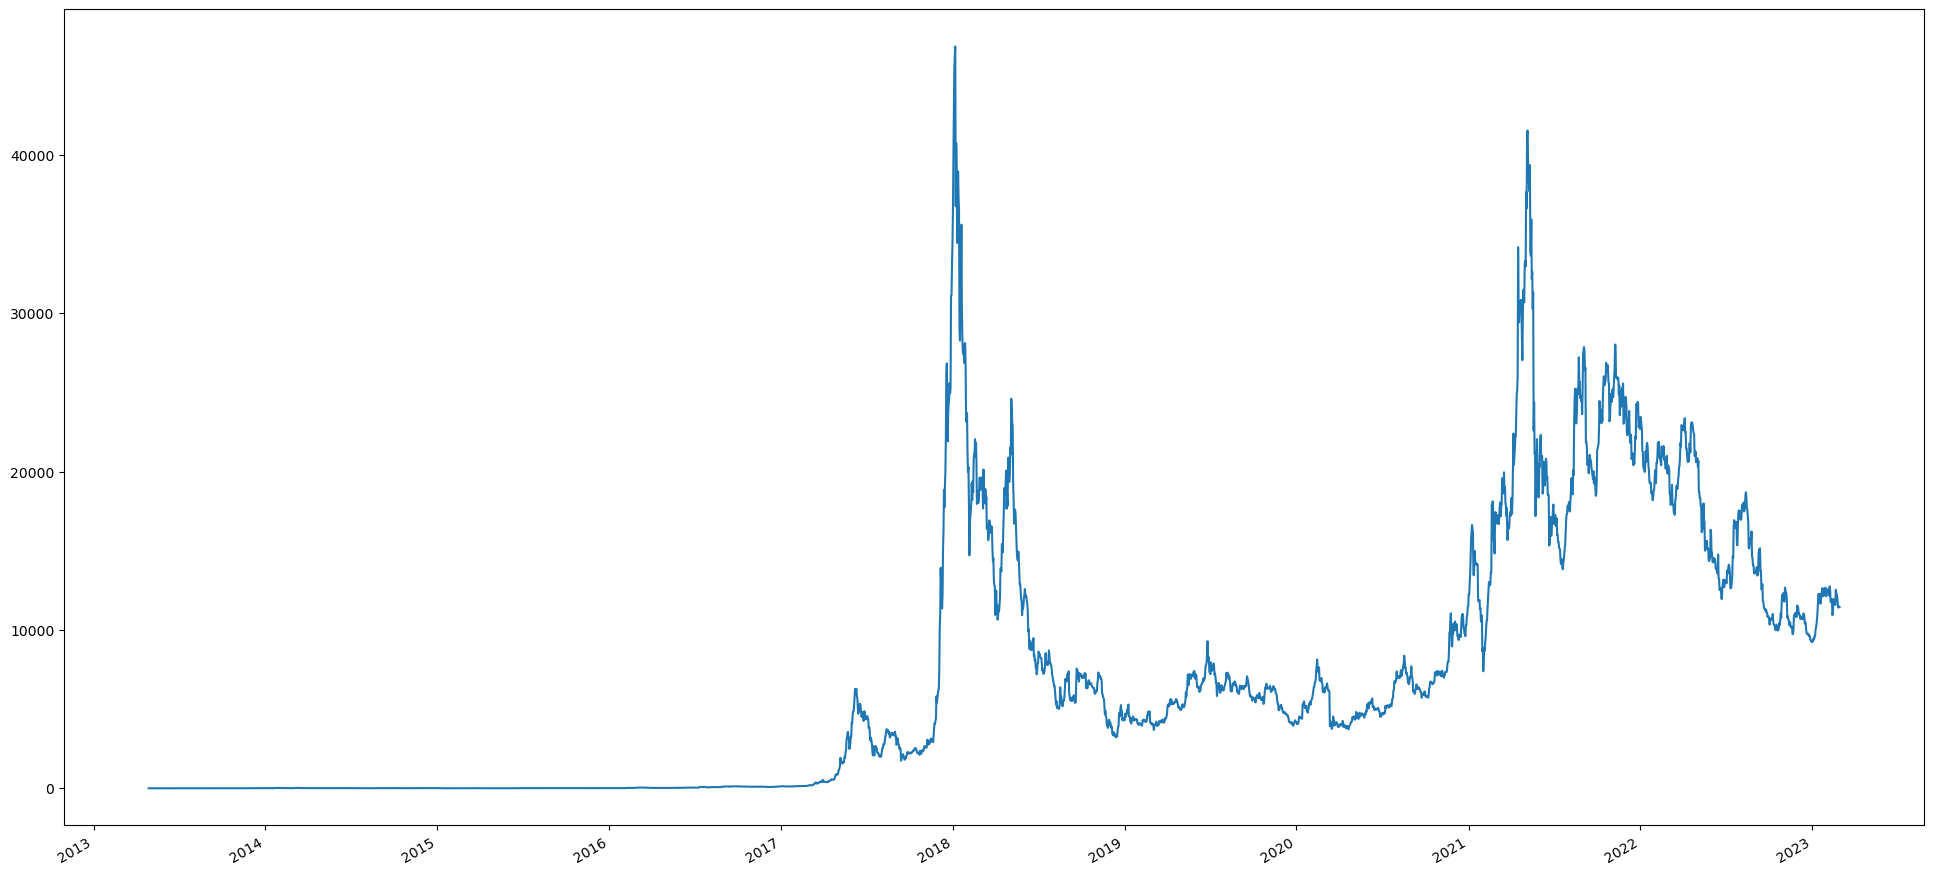

In [107]:
((q3_weight * daily_return.shift(-1)).sum(axis=1) + 1).cumprod().plot(figsize=(24,12));